## Importing and installing need libraries

In [38]:
import numpy as np
from tensorflow.keras import Model as Model_
from tensorflow.keras.layers import Input, ReLU, LSTM, GRU, SimpleRNN, Dense, TimeDistributed, Bidirectional, GaussianNoise 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential, model_from_json
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from itertools import chain
import tensorflow_model_remediation.min_diff.losses.mmd_loss as MMD

print(tf.__version__)

2.10.0


## Dataset Reading and Preprocessing

### Listing all the movable joints in the human skeleton

In [3]:
#Was done in the preprocessing in [1]
# Joints in H3.6M -- data has 32 joints, but only 17 that move; these are the indices.
H36M_NAMES = ['']*32
H36M_NAMES[0]  = 'Hip'
H36M_NAMES[1]  = 'RHip'
H36M_NAMES[2]  = 'RKnee'
H36M_NAMES[3]  = 'RFoot'
H36M_NAMES[6]  = 'LHip'
H36M_NAMES[7]  = 'LKnee'
H36M_NAMES[8]  = 'LFoot'
H36M_NAMES[12] = 'Spine'
H36M_NAMES[13] = 'Thorax'
H36M_NAMES[14] = 'Neck/Nose'
H36M_NAMES[15] = 'Head'
H36M_NAMES[17] = 'LShoulder'
H36M_NAMES[18] = 'LElbow'
H36M_NAMES[19] = 'LWrist'
H36M_NAMES[25] = 'RShoulder'
H36M_NAMES[26] = 'RElbow'
H36M_NAMES[27] = 'RWrist'

### A class to Read and Combine all the Dataset files

In [4]:
import os
import re

class Dataset_loading:
    def __init__(self, dir_path, include_dimension = 2, sample_size = 50,
                 total_classes = 17, datatype = 'float32', include_movable_joints = False):
        
        #Dataset Directory path
        self.dir_path = dir_path
        
        #Which Dimension file to include, possible values: 2 and 3
        self.include_dimension = include_dimension
        
        #Total frames in one Sample
        self.sample_size = sample_size
        
        #Default Datatype for all the samples
        self.datatype = datatype
        
        #Activity classes to include
        self.classes = ['SittingDown', 'Walking', 'Directions', 'Discussion', 'Sitting', 'Phoning', 'Eating', 'Posing', 'Greeting', 'Smoking']
        
        #Total activity classes
        self.total_classes = len(self.classes)
        
        #Subject Folders names in the Dataset
        self.internal_folders = ['S1', 'S5','S6','S7','S8','S9','S11']

        #Boolean value indicating whether to include all joints or only the movable joints.
        self.include_movable_joints = include_movable_joints
        
        self.movable_joints = [0, 1, 2, 3, 6, 7, 8, 12, 13, 14, 15, 17, 18, 19, 25, 26, 27]
    
    def read_dataset(self):
        try:
            #Contains all the different activity vectors
            activity_vector = {}
            
            #Contains the overall dataset
            sampled_data = None
            
            #Based on dimensions, which folder to use for extracting the dataset files
            data_folder = 'Poses_D2_Positions' if self.include_dimension == 2 else 'Poses_D3_Positions'
            
            #Checking if the dataset path is valid
            if not os.path.exists(self.dir_path):
                print('The Data Directory Does not Exist!')
                return None

            #Iterating over all the subject folders
            for fld in self.internal_folders:
                #Iterating for each file in the specified folder
                for file in os.listdir(os.path.join(self.dir_path, fld, data_folder)):
                    #Extracting the activity from the filename
                    activity = self.__extract_activity(file)
                    
                    if activity not in self.classes:
                        continue
                    
                    #Reading the CSV file using Pandas
                    data = pd.read_csv(os.path.join(self.dir_path, fld, data_folder, file), header=None)

                    #Formulating the activity vector using one hot encoding
                    if activity not in activity_vector:
                        total_keys = len(activity_vector.keys())
                        activity_vector[activity] = np.zeros(self.total_classes)
                        activity_vector[activity][total_keys] = 1
                    vector = activity_vector[activity]
                    
                    #Sampling the dataset
                    grouped_sample = self.__group_samples(data, self.sample_size, vector)
                    sampled_data = grouped_sample if sampled_data is None else np.append(sampled_data, grouped_sample, axis=0)
            
            #Changing the Datatype
            sampled_data = sampled_data.astype(self.datatype)
            
            return sampled_data
        except Exception as e:
            print(e)
    
    def __extract_activity(self, filename):
        try:
            #Extracting the filename and excluding the extension
            name = os.path.splitext(filename)[0]
            
            #Substituting the empty string with characters other than english alphabets
            activity = re.sub('[^A-Za-z]+' , '' , name)
            return activity
        except Exception as e:
            print(e)
    
    def __group_samples(self, dataset, sample_size, activity):
        try:
            #Checking if the dataset is a Pandas Dataframe
            if not isinstance(dataset, pd.DataFrame):
                print('Expecting Pandas Dataframe, but got {}'.format(type(dataset)))
                return None
            
            if self.include_movable_joints:
                joints = list(chain.from_iterable((jt*2, (jt*2)+1) for jt in self.movable_joints))
                dataset = dataset.iloc[: , joints].copy()

            #Appending activity class to each row in the dataset
            dataset = pd.concat([dataset, pd.DataFrame(np.tile(activity, (dataset.shape[0],1)))], axis=1)
            
            #Reshaping the dataset into sample batches
            total_samples = dataset.shape[0]//sample_size
            total_features = dataset.shape[1]
            grouped_rows = dataset.to_numpy()[:total_samples*self.sample_size].reshape((-1,self.sample_size, total_features))
            
            return grouped_rows
        except Exception as e:
            print(e)

### A function to split Dataset into Features and Labels

In [5]:
def split_to_features_labels(dataset, input_sequance_size=10, total_features=64) :
    """
    Function for splitting the data into features(with sequance size=iput_sequance_size)
    and labels which should be the remainder of the sample length 
    """
    assert input_sequance_size < dataset.shape[1], f"input sequance should be smaller than the total sample size"
    features = dataset[:, np.s_[0:input_sequance_size], :]
    labels = dataset[:,np.s_[input_sequance_size:], :total_features]
    
    return features, labels

### A function for downsampling the dataset on number of frames

In [6]:
def downsampling(sampled_data, downsample_technique = 'skip'):
    """
    The function used to down-sample the data using two different techniques. In Skip, one frame is skipped consecutively and
    in the mean technique, two frames are averaged consecutively.
    """
    samples_per_batch = int(sampled_data.shape[1] / 2)
    total_features = sampled_data.shape[2]
    downsampled_data = np.empty(shape=(0, samples_per_batch, total_features))
    
    if downsample_technique == 'skip':
        downsampled_data = sampled_data[:,::2,:]
    else:
        for batch in sampled_data:
            averaged_batch = np.empty(shape=(0, total_features))
            for i in range(0, batch.shape[0], 2):
                averaged_batch = np.append(averaged_batch, np.mean(batch[i:i+2, :], axis = 0).reshape((1, total_features)), axis = 0)
            downsampled_data = np.append(downsampled_data, averaged_batch.reshape((1, samples_per_batch, total_features)), axis = 0)
    return downsampled_data

### Adding more preprocessing steps (Normalization and gussian noise)

In [7]:
def preprocess_data(sampled_dataX, sampled_dataY, normalize=True, add_noise=True
                    , stddev=0.05) :
    """
    Function to preprocess data by normalizing input features and adding guassian
    noise to increase model robustness
    """  
    if normalize :
        sampled_dataX =  tf.keras.utils.normalize(sampled_dataX, axis=2)
    if add_noise :
        guassian_noise_layer = tf.keras.layers.GaussianNoise(stddev=stddev)
        sampled_dataX = guassian_noise_layer(sampled_dataX)
    return sampled_dataX, sampled_dataY

## Defining different components of the model

### Defining the Interpolation Layer

In [33]:
class InterpolationLayer(tf.keras.layers.Layer):
    """
    Custom interpolation layer extending the keras layer class
    it has one attribute num_frames to be interpolated between each two consecutive 
    timesteps
    it has one main function interpolateFrames  
    """
  
    def __init__(self, num_frames=5):
        super(InterpolationLayer, self).__init__()
        self.num_frames = num_frames

    def interpolateFrames(self, inputs):
        """
        Takes input tensors of shape(batch_size, timesteps, features)
        returns interpolated frames with shape(batch_size, timesteps*num_frames, features)
        """
        
        batch_size = inputs.shape[0]
        timesteps = inputs.shape[1]
        features = inputs.shape[2]
        interpolated_frames = tf.zeros([0, features])
        
        for batch in tf.range(tf.shape(inputs)[0]) :
            tf.autograph.experimental.set_loop_options(
            shape_invariants=[(interpolated_frames, tf.TensorShape([None, features]))])
            for t in range(timesteps) :
                for j in range(self.num_frames) :
                    X_i0 = inputs[batch, t]
                    if(t == timesteps-1) :
                        X_i1 = inputs[batch, t]
                    else :  
                        X_i1 = inputs[batch, t+1]
                    alpha_j = j/self.num_frames
                    current_frame = alpha_j*X_i0 + (1-alpha_j)*X_i1
                    current_frame = tf.reshape(current_frame, [1, features])
                    interpolated_frames = tf.concat((interpolated_frames, current_frame), axis=0)

        interpolated_frames = tf.reshape(interpolated_frames,[tf.shape(inputs)[0], (timesteps)*self.num_frames, features])
        return interpolated_frames

    def call(self, inputs):
        return self.interpolateFrames(inputs)

### Trying to create the Keras GlocalNet model through a custom function

In [9]:
def create_glocalNet_model(enocder_hidden_state=200, decoder_hidden_state=200, 
                 output_diminsion=64, input_diminsions=74, LSTM_dropout=0.25, dense_activation='relu',
                 interpolation_frames=5, exclude_locgen=False) :
    #Glogen encoder
    encoder_inputs = Input(shape=(10, input_diminsions))
    encoder = LSTM(enocder_hidden_state, return_sequences=True, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]
    #Glogen decoder
    decoder_lstm = LSTM(decoder_hidden_state, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(encoder_outputs,
                                        initial_state=encoder_states)
    decoder_dense = TimeDistributed(Dense(output_diminsion, activation=dense_activation))
    decoder_outputs = decoder_dense(decoder_outputs)

    #Interpolation layer
    interpolation_layer = InterpolationLayer(num_frames=interpolation_frames)
    interpolation_output = interpolation_layer(decoder_outputs)
    #return the model if execlude_locgen is true
    if(exclude_locgen) :
        return Model_(encoder_inputs, interpolation_output)
    
    #Locgen encoder
    encoder_locgen = LSTM(enocder_hidden_state, return_sequences=True, return_state=True)
    encoder_outputs_locgen, state_h_locgen, state_c_locgen = encoder_locgen(interpolation_output)
    encoder_states_locgen = [state_h_locgen, state_c_locgen]
    #Locgen decoder
    decoder_lstm_locgen = LSTM(decoder_hidden_state, return_sequences=True, return_state=True)
    decoder_outputs_locgen, _, _ = decoder_lstm(encoder_outputs_locgen,
                                        initial_state=encoder_states_locgen)
    decoder_dense_locgen = TimeDistributed(Dense(output_diminsion, activation=dense_activation))
    glocalNet_output = decoder_dense_locgen(decoder_outputs_locgen)
    return Model_(encoder_inputs, glocalNet_output)


### Custom GlocalNet class

In [32]:
class GlocalNet(Model_):
    """
    A full GlocalNet implementation include the three main stages
    Glogen generating initial sparse frames
    Interpolation layer generating dense frames from Glogen output
    Locgen generating the final output by smoothing the interpolated frames
    """
    def __init__(self, enocder_hidden_state=200, decoder_hidden_state=200, 
                 output_diminsion=64, LSTM_dropout=0.25, dense_activation='relu',
                 interpolation_frames=5, exclude_locgen=False):
        super(GlocalNet, self).__init__()
        self.exclude_locgen = exclude_locgen
        #Glogen layers
        self.glogen_encoder = LSTM(enocder_hidden_state, return_state=True
                                   , return_sequences=True, dropout=LSTM_dropout)
        self.glogen_decoder = LSTM(decoder_hidden_state, return_sequences=True,
                                   return_state=True, dropout=LSTM_dropout)
        #Locgen layers
        self.locgen_encoder = LSTM(enocder_hidden_state, return_sequences=True,
                                   return_state=True, dropout=LSTM_dropout)
        self.locgen_decoder = LSTM(decoder_hidden_state, return_sequences=True,
                                   return_state=True, dropout=LSTM_dropout)
        #Glogen dense layer
        self.glogen_dense_layer = TimeDistributed(Dense(output_diminsion,
                                                        activation=dense_activation)) 
        #Interpolation layer
        self.interpolation_layer = InterpolationLayer(num_frames=interpolation_frames)
        #Locgen dense layer
        self.locgen_dense_layer = TimeDistributed(Dense(output_diminsion,
                                                        activation=dense_activation)) 
    def call(self, inputs):
        #Glogen calls      
        encoder_outputs, state_h, state_c = self.glogen_encoder(inputs)
        encoder_states = [state_h, state_c]
        output, _, _ = self.glogen_decoder(encoder_outputs, initial_state=encoder_states)
        glogen_output = self.glogen_dense_layer(output)

        #Interpolation call
        interpolated_frames = self.interpolation_layer(glogen_output)
        
        if self.exclude_locgen :
            return interpolated_frames

        #Locgen calls
        locgen_encoder_outputs, locgen_state_h, locgen_state_c = self.locgen_encoder(interpolated_frames)
        locgen_encoder_states = [locgen_state_h, locgen_state_c]
        locgen_output, _, _ = self.locgen_decoder(locgen_encoder_outputs, initial_state=locgen_encoder_states)
        final_output = self.locgen_dense_layer(locgen_output)
        return final_output

### Defining different Types of Loss functions

In [11]:
class Loss() :
    """
    Joint loss class with two weight attributes for two different losses
    first one is the loss joint and the second is the loss_motion_flow
    """
    
    def __init__(self, lambda1=0.5, lambda2=0.5) :
        self.lambda1 = lambda1
        self.lambda2 = lambda2

    def loss_joint(self, predicted_sequance_batch, target_sequance_batch) :
        """
        Loss between the joint positions and its corresponding counterparts in the groundtruth
        """
        diff_norm_2 = tf.math.reduce_sum(tf.square(tf.subtract(predicted_sequance_batch, target_sequance_batch)), axis=2)
        return tf.reduce_sum(diff_norm_2, axis=1) 

    def loss_motion_flow(self, predicted_sequance_batch, target_sequance_batch) :
        """
        Loss between the motion flow of predicted sequance and the ground truth
        where the motion flow is the euclidean distance between each two consecutive frames
        """
        predictions_tomporal_diffs = tf.experimental.numpy.diff(predicted_sequance_batch, axis=1)
        real_tomporal_diffs = tf.experimental.numpy.diff(target_sequance_batch, axis=1)
        prediction_motion_flow_diff_norm_2 = tf.reduce_sum(tf.square(tf.subtract(predictions_tomporal_diffs, real_tomporal_diffs)), axis=2)
        return tf.reduce_sum(prediction_motion_flow_diff_norm_2, axis=1)

    def total_loss(self, target_sequance_batch, predicted_sequance_batch) :
        """
        calculating the total loss through a combination of the joint_loss and motion_flow_loss
        """
        joints_loss = self.loss_joint(predicted_sequance_batch, target_sequance_batch)
        motion_flow_loss = self.loss_motion_flow(predicted_sequance_batch, target_sequance_batch)
        return self.lambda1*joints_loss + self.lambda2*motion_flow_loss

### Defining different types of Evaluation Metrics

In [12]:
class Metrics():
    """
    A class containing different types of Evaluation Metrics.
    """
    
    def __init__(self, mmd_kernel='gaussian') :
        self.mmd_kernel = mmd_kernel
    
    def custom_sequence_MMD_loss(self, target_sequance_batch, predicted_sequance_batch):
        """
        Calculating the Sequence MMD Loss between prediction and the ground Truth.
        Additionally combining the last two dimensions 
        """
        mmd_loss = MMD.MMDLoss(kernel=self.mmd_kernel)
        
        total_batches = predicted_sequance_batch.shape[0]
        frames_per_batch = predicted_sequance_batch.shape[1] * predicted_sequance_batch.shape[2]
        
        return mmd_loss(tf.reshape(predicted_sequance_batch, [total_batches, frames_per_batch]),
                        tf.reshape(target_sequance_batch, [total_batches, frames_per_batch]))
    
    def NPSS(self, euler_gt_sequences, euler_pred_sequences):
        """
        A function to compute the Normalized Power Spectrum Similarity (NPSS) metric between predictions and the ground Truth [2] and [3].
        """        
        # computing 1) fourier coeffs 2)power of fft 3) normalizing power of fft dim-wise 4) cumsum over freq. 5) EMD 
        gt_fourier_coeffs = np.zeros(euler_gt_sequences.shape, dtype = 'complex_')
        pred_fourier_coeffs = np.zeros(euler_pred_sequences.shape, dtype = 'complex_')

        # power vars
        gt_power = np.zeros((gt_fourier_coeffs.shape))
        pred_power = np.zeros((gt_fourier_coeffs.shape))

        # normalizing power vars
        gt_norm_power = np.zeros(gt_fourier_coeffs.shape)
        pred_norm_power = np.zeros(gt_fourier_coeffs.shape)

        cdf_gt_power = np.zeros(gt_norm_power.shape)
        cdf_pred_power = np.zeros(pred_norm_power.shape)

        emd = np.zeros(cdf_pred_power.shape[0:3:2])

        # used to store powers of feature_dims and sequences used for avg later
        seq_feature_power = np.zeros(euler_gt_sequences.shape[0:3:2])
        power_weighted_emd = 0

        for s in range(euler_gt_sequences.shape[0]):

            for d in range(euler_gt_sequences.shape[2]):
                gt_fourier_coeffs[s,:,d] = np.fft.fft(euler_gt_sequences[s,:,d]) # slice is 1D array
                pred_fourier_coeffs[s,:,d] = np.fft.fft(euler_pred_sequences[s,:,d])

                # computing power of fft per sequence per dim
                gt_power[s,:,d] = np.square(np.absolute(gt_fourier_coeffs[s,:,d]))
                pred_power[s,:,d] = np.square(np.absolute(pred_fourier_coeffs[s,:,d]))

                # matching power of gt and pred sequences
                gt_total_power = np.sum(gt_power[s,:,d])
                pred_total_power = np.sum(pred_power[s,:,d])
                #power_diff = gt_total_power - pred_total_power

                # adding power diff to zero freq of pred seq
                #pred_power[s,0,d] = pred_power[s,0,d] + power_diff

                # computing seq_power and feature_dims power 
                seq_feature_power[s,d] = gt_total_power

                # normalizing power per sequence per dim
                if gt_total_power != 0:
                    gt_norm_power[s,:,d] = gt_power[s,:,d] / gt_total_power 

                if pred_total_power !=0:
                    pred_norm_power[s,:,d] = pred_power[s,:,d] / pred_total_power

                # computing cumsum over freq
                cdf_gt_power[s,:,d] = np.cumsum(gt_norm_power[s,:,d]) # slice is 1D
                cdf_pred_power[s,:,d] = np.cumsum(pred_norm_power[s,:,d])

                # computing EMD 
                emd[s,d] = np.linalg.norm((cdf_pred_power[s,:,d] - cdf_gt_power[s,:,d]), ord=1)

        # computing weighted emd (by sequence and feature powers)
        power_weighted_emd = np.average(emd, weights=seq_feature_power) 

        return power_weighted_emd

### A function to start the experiment of training and evaluating the model

In [85]:
def run_experiment(sampled_dataX, sampled_dataY, learning_rate=0.002, lambda1=0.5,
                   lambda2=0.5, use_mse=False, use_MMD=False, metrics=None, output_diminsion=64,
                   batch_size=100, epochs=50, validation_split=0.2, activation="relu",
                   dropout=0.25, exclude_locgen=False, interpolate_frames = 5) :
    """
    Method takes all hyperparameters as input paramters and returns the model and history as
    a result
    """
    glocal_model = GlocalNet(dense_activation=activation, LSTM_dropout=dropout,
                             exclude_locgen=exclude_locgen,
                             output_diminsion=output_diminsion, 
                             interpolation_frames = interpolate_frames)
    if use_mse :
        loss_function = tf.keras.losses.mean_squared_error
    elif use_MMD :
        loss_function = Loss().custom_sequence_MMD_loss
    else :
        loss_function = Loss(lambda1=lambda1, lambda2=lambda2).total_loss

    glocal_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                         loss=loss_function, metrics=metrics, run_eagerly=False)
    history = glocal_model.fit(sampled_dataX, sampled_dataY, batch_size=batch_size, 
                               epochs=epochs, validation_split=validation_split)
    return history, glocal_model

### A function to Resume the experiment of training and evaluating the model

In [14]:
def resume_training(glocal_model, sampled_dataX, sampled_dataY, learning_rate=0.002, lambda1=0.5,
                   lambda2=0.5, use_mse=False, use_MMD=False, metrics=None,
                   batch_size=100, epochs=50, validation_split=0.2) :
    """
    function to resume training of a model
    """
    if use_mse :
        loss_function = tf.keras.losses.mean_squared_error
    elif use_MMD :
        loss_function = Loss().custom_sequence_MMD_loss
    else :
        loss_function = Loss(lambda1=lambda1, lambda2=lambda2).total_loss

    glocal_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss=loss_function, metrics=metrics)
    history = glocal_model.fit(sampled_dataX, sampled_dataY,
                            batch_size=batch_size,
                            epochs=epochs, validation_split=validation_split)
    return history, glocal_model

### A function to visualize certain frames from the Dataset

In [16]:
def visualize_frames(sample, dynamic_joints_only=False,
                    num_frames_to_visualize=10,
                    joints_to_ignore=[4,5,9,10,11,16,20,21,22,23,24,28,29,30,31]) :
    """
    Visualization function to draw a certain number of frames in a given sample
    ignoring the joints mentioned in joints_to_ignore array
    """
    assert num_frames_to_visualize <= sample.shape[0], f"number of frames should be less than or equal to the total frames in the sample"
    fig, axs = plt.subplots(ncols=num_frames_to_visualize, figsize=(15, 8))
    fig.tight_layout(pad=1.0)
    for t in range(num_frames_to_visualize) :
        #Removing unnecessary joints for visualization
        if(dynamic_joints_only) :
            #Check if no joints needs to be removed
            truncated_frame = sample[t]
        else :
            #Removing the joints based on joints_to_ignore
            joints_to_ignore_2d = [element * 2 for element in joints_to_ignore]
            for i in range(len(joints_to_ignore_2d)) :
                joints_to_ignore_2d.append(joints_to_ignore_2d[i]+1)
            truncated_frame = np.delete(sample[t], joints_to_ignore_2d)   

        #In case of including only moving joints for Human3.6M(17 joints)      
        x_axis_array = truncated_frame[0:34:2]
        y_axis_array = truncated_frame[1:35:2]
        #Scattering all the 17 joints
        axs[t].scatter(x_axis_array, y_axis_array)
        #Plotting right leg
        axs[t].plot(x_axis_array[:4], y_axis_array[:4], "tab:blue")
        #plotting left leg
        axs[t].plot(x_axis_array[[0, 4, 5, 6]], y_axis_array[[0, 4, 5, 6]])
        #plotting from hip to head
        axs[t].plot(x_axis_array[[0, 7, 8, 9, 10]], y_axis_array[[0, 7, 8, 9, 10]])
        #plotting from neck to left shoulder
        axs[t].plot(x_axis_array[[9, 11, 12, 13]], y_axis_array[[9, 11, 12, 13]])
        #plotting from neck to right shoulder
        axs[t].plot(x_axis_array[[9, 14, 15, 16]], y_axis_array[[9, 14, 15, 16]])
        axs[t].invert_yaxis()
        axs[t].set_xticks([])
        axs[t].set_yticks([])
    plt.show()

## Experimentations

### Reading and Preprocessing the Dataset

In [54]:
sampled_data_short_term = Dataset_loading('./H3.6csv', sample_size=20, include_movable_joints=False).read_dataset()

In [17]:
#For long term prediction, we need a sample size of 60(10 frames input sequance, 50 frames predicted sequance)
sampled_data_all = Dataset_loading('./H3.6csv', sample_size=60, include_movable_joints=False).read_dataset()

In [18]:
#For long term prediction, we need a sample size of 60(10 frames input sequance, 50 frames predicted sequance)
sampled_data_movable = Dataset_loading('./H3.6csv', sample_size=60, include_movable_joints=True).read_dataset()

In [53]:
sampled_data_all.shape

(25520, 60, 74)

In [19]:
#To make the data divisible for batch size of 20
total_batches = sampled_data_all.shape[0]
sampled_data_all = sampled_data_all[:total_batches-(total_batches%20)]

In [20]:
#To make the data divisible for batch size of 20
sampled_data_movable = sampled_data_movable[:total_batches-(total_batches%20)]

In [56]:
total_batches_short_term = sampled_data_short_term.shape[0]
sampled_data_short_term = sampled_data_short_term[:total_batches_short_term-(total_batches_short_term%20)]

In [21]:
sampled_dataX_all, sampled_dataY_all = split_to_features_labels(sampled_data_all, input_sequance_size=10, total_features=64)

In [22]:
sampled_dataX_movable, sampled_dataY_movable = split_to_features_labels(sampled_data_movable, input_sequance_size=10, total_features=34)

In [59]:
sampled_dataX_short_term, sampled_dataY_short_term = split_to_features_labels(sampled_data_short_term, input_sequance_size=10, total_features=64)

In [60]:
print('Dataset with all features(short term)')
print('Total Samples: {}\nTotal Frames: {}\nTotal Features: {}'.format(sampled_dataY_short_term.shape[0],
                                                                       sampled_dataY_short_term.shape[1],
                                                                       sampled_dataY_short_term.shape[2]))

Dataset with all features(short term)
Total Samples: 77140
Total Frames: 10
Total Features: 64


In [23]:
print('Dataset with all features')
print('Total Samples: {}\nTotal Frames: {}\nTotal Features: {}'.format(sampled_dataY_all.shape[0],
                                                                       sampled_dataY_all.shape[1],
                                                                       sampled_dataY_all.shape[2]))

Dataset with all features
Total Samples: 25520
Total Frames: 50
Total Features: 64


In [24]:
print('Dataset with only movable features')
print('Total Samples: {}\nTotal Frames: {}\nTotal Features: {}'.format(sampled_dataY_movable.shape[0],
                                                                       sampled_dataY_movable.shape[1],
                                                                       sampled_dataY_movable.shape[2]))

Dataset with only movable features
Total Samples: 25520
Total Frames: 50
Total Features: 34


### Adding Noise and Downsampling to improve model performance and robustness

In [25]:
preprocessed_sampled_dataX_all, preprocessed_sampled_dataY_all = preprocess_data(sampled_dataX_all, sampled_dataY_all)

In [26]:
preprocessed_sampled_dataX_movable, preprocessed_sampled_dataY_movable = preprocess_data(sampled_dataX_movable, sampled_dataY_movable) 

In [27]:
downsampled_data_all = downsampling(sampled_data_all, 'skip')
downsampled_data_movable = downsampling(sampled_data_movable, 'skip')

In [28]:
downsampled_dataX_all, downsampled_dataY_all = split_to_features_labels(downsampled_data_all, input_sequance_size=10, total_features=64)
preprocessed_downsampled_dataX_all, preprocessed_downsampled_dataY_all = preprocess_data(downsampled_dataX_all, downsampled_dataY_all)

In [29]:
downsampled_dataX_movable, downsampled_dataY_movable = split_to_features_labels(downsampled_data_movable, input_sequance_size=10, total_features=34)
preprocessed_downsampled_dataX_movable, preprocessed_downsampled_dataY_movable = preprocess_data(downsampled_dataX_movable, downsampled_dataY_movable)

### Running experiments with different hyperparameters

#### GlocalNet Base Implementation Experiments

##### Experiment Running with MSE Loss and MMD metric with Guassian Kernel

In [ ]:
history_model1, glocal_model1 = run_experiment(sampled_dataX_all, sampled_dataY_all, epochs=10,
                                                 batch_size=20, use_mse=True, validation_split=0.0, metrics=[tf.keras.losses.mean_absolute_percentage_error,
                                                 Metrics().custom_sequence_MMD_loss])

##### Experiment Running with Joint Loss and MMD metric with Guassian Kernel

In [ ]:
history_model2, glocal_model2 = run_experiment(sampled_dataX_all, sampled_dataY_all, epochs=10, batch_size=20, lambda1=0.5, lambda2=0.5, 
                                               validation_split=0.0, metrics=[tf.keras.losses.mean_absolute_percentage_error,
                                                 Metrics().custom_sequence_MMD_loss])

##### Experiment Running with MSE and MMD metric with Laplacian Kernel

In [ ]:
history_model3, glocal_model3 = run_experiment(sampled_dataX_all, sampled_dataY_all, epochs=10, batch_size=20, use_mse=True, validation_split=0.0,
                                               metrics=[tf.keras.losses.mean_absolute_percentage_error, 
                                                        Metrics(mmd_kernel="laplacian").custom_sequence_MMD_loss])

##### Experiment Running with Joint Loss and MMD metric with Laplacian Kernel

In [ ]:
history_model4, glocal_model4 = run_experiment(sampled_dataX_all, sampled_dataY_all, epochs=10, batch_size=20, lambda1=0.5, lambda2=0.5, 
                                               validation_split=0.0, metrics=[tf.keras.losses.mean_absolute_percentage_error, 
                                                                              Metrics(mmd_kernel="laplacian").custom_sequence_MMD_loss])

##### Experiment Running with MSE, MMD metric and without Locgen

In [ ]:
history_model5, glocal_model5 = run_experiment(sampled_dataX_all, sampled_dataY_all, epochs=10, batch_size=20, use_mse=True, validation_split=0.0, 
                                               exclude_locgen=True, metrics=[tf.keras.losses.mean_absolute_percentage_error, 
                                                                             Metrics().custom_sequence_MMD_loss])

#### Advancements in the Base Paper

##### Running Experiment with whole Preprocessed Data and without Downsampling

In [ ]:
history_model6, glocal_model6 = run_experiment(preprocessed_sampled_dataX_all, preprocessed_sampled_dataY_all, batch_size=20, dropout=0.0,
                                               epochs=50, use_mse=True, validation_split=0.0, metrics=[Metrics().custom_sequence_MMD_loss, 
                                                                                                       tf.keras.losses.mean_absolute_percentage_error])

##### Running Experiment with whole Preprocessed Data and without Downsampling and Locgen

In [ ]:
history_model7, glocal_model7 = run_experiment(preprocessed_sampled_dataX_all, preprocessed_sampled_dataY_all, batch_size=20, dropout=0.0, 
                                               exclude_locgen=True, epochs=50, use_mse=True, validation_split=0.0,
                                               metrics=[Metrics().custom_sequence_MMD_loss, tf.keras.losses.mean_absolute_percentage_error])

##### Running Experiment with Preprocessed movable Datapoints and without Downsampling

In [ ]:
history_model8, glocal_model8 = run_experiment(preprocessed_sampled_dataX_movable, preprocessed_sampled_dataY_movable, batch_size=20, dropout=0.0,
                                               epochs=50, use_mse=True, validation_split=0.0,
                                               metrics=[Metrics().custom_sequence_MMD_loss, tf.keras.losses.mean_absolute_percentage_error])

##### Running Experiment with Preprocessed movable Datapoints and without Downsampling and Locgen

In [ ]:
history_model9, glocal_model9 = run_experiment(preprocessed_sampled_dataX_movable, preprocessed_sampled_dataY_movable, batch_size=20, dropout=0.0, 
                                               exclude_locgen=True, epochs=50, use_mse=True, validation_split=0.0,
                                               metrics=[Metrics().custom_sequence_MMD_loss, tf.keras.losses.mean_absolute_percentage_error])

##### Running Experiment with whole Downsampled data

In [ ]:
history_model10, glocal_model10 = run_experiment(preprocessed_downsampled_dataX_all, preprocessed_downsampled_dataY_all, batch_size=20, dropout=0.0,
                                                 epochs=50, use_mse=True, output_diminsion=34, validation_split=0.0, interpolate_frames = 2,
                                                 metrics=[Metrics().custom_sequence_MMD_loss, tf.keras.losses.mean_absolute_percentage_error])

##### Running Experiment with whole Downsampled data and without Locgen

In [ ]:
history_model11, glocal_model11 = run_experiment(preprocessed_downsampled_dataX_all, preprocessed_downsampled_dataY_all, batch_size=20, dropout=0.0, 
                                                 exclude_locgen=True, epochs=50, use_mse=True, output_diminsion=34, validation_split=0.0, 
                                                 interpolate_frames = 2, metrics=[Metrics().custom_sequence_MMD_loss, 
                                                                                 tf.keras.losses.mean_absolute_percentage_error])

##### Running Experiment with Downsampled movable datapoints

In [ ]:
history_model12, glocal_model12 = run_experiment(preprocessed_downsampled_dataX_movable, preprocessed_downsampled_dataY_movable, batch_size=20, 
                                                 dropout=0.0, epochs=50, use_mse=True, output_diminsion=34, validation_split=0.0, 
                                                 interpolate_frames = 2, metrics=[Metrics().custom_sequence_MMD_loss, 
                                                                                  tf.keras.losses.mean_absolute_percentage_error])

##### Running Experiment with Downsampled movable datapoints and without Locgen

In [ ]:
history_model13, glocal_model13 = run_experiment(preprocessed_downsampled_dataX_movable, preprocessed_downsampled_dataY_movable, batch_size=20, 
                                                 dropout=0.0, exclude_locgen=True, epochs=50, use_mse=True, output_diminsion=34,validation_split=0.0, 
                                                 interpolate_frames = 2, metrics=[Metrics().custom_sequence_MMD_loss, 
                                                                                  tf.keras.losses.mean_absolute_percentage_error])

##### Running Experiment with Downsampled movable datapoints and NPSS evaluation Metric

In [ ]:
history_model14, glocal_model14 = run_experiment(preprocessed_downsampled_dataX_movable, preprocessed_downsampled_dataY_movable, batch_size=20, 
                                                 dropout=0.0, epochs=50, use_mse=True, output_diminsion=34, validation_split=0.0, 
                                                 interpolate_frames = 2, metrics=[Metrics().NPSS, 
                                                                                  tf.keras.losses.mean_absolute_percentage_error])

#### Simple Baseline Model for short term predictions (10 frames)

In [92]:
class BasicRNN(Model_):
    """
    simple many to many RNN model
    """
    def __init__(self, output_diminsions=64, RNN_type="classical", activation="relu"):
        super(BasicRNN, self).__init__()
        possible_RNN_types = ["classical", "LSTM", "GRU"]
        assert RNN_type in possible_RNN_types, f"RNN_type should be one of the valid values ['classical', 'LSTM', 'GRU']"
        if(RNN_type == "classical") :
            self.ruccernt_layer = SimpleRNN(output_diminsions, return_sequences=True)
        elif(RNN_type == "LSTM") : 
            self.ruccernt_layer = LSTM(output_diminsions, return_sequences=True)
        else :
            self.ruccernt_layer = GRU(output_diminsions, return_sequences=True)
        self.dense_layer = TimeDistributed(Dense(output_diminsions,
                                                        activation=activation)) 

    def call(self, input) :
        output = self.ruccernt_layer(input)
        output = self.dense_layer(output)
        return output        

#### Running simple LSTM model with Relu

In [73]:
simple_RNN1 = BasicRNN(RNN_type="LSTM")

In [75]:
history_simple_RNN1, simple_RNN1 = resume_training(simple_RNN1, sampled_dataX_short_term, sampled_dataY_short_term, epochs=50, batch_size=20, use_mse=True, validation_split=0.0,
  metrics=[tf.keras.losses.mean_absolute_percentage_error, Metrics().custom_sequence_MMD_loss])

Epoch 1/50
3857/3857 [==============================] - 22s 5ms/step - loss: 79597.4688 - mean_absolute_percentage_error: 43.2617 - custom_sequence_MMD_loss: 0.0500
Epoch 2/50
3857/3857 [==============================] - 21s 5ms/step - loss: 62388.8125 - mean_absolute_percentage_error: 35.1288 - custom_sequence_MMD_loss: 0.0500
Epoch 3/50
3857/3857 [==============================] - 21s 5ms/step - loss: 60569.7930 - mean_absolute_percentage_error: 34.4963 - custom_sequence_MMD_loss: 0.0500
Epoch 4/50
3857/3857 [==============================] - 21s 5ms/step - loss: 60552.6094 - mean_absolute_percentage_error: 34.5134 - custom_sequence_MMD_loss: 0.0500
Epoch 5/50
3857/3857 [==============================] - 18s 5ms/step - loss: 60546.4023 - mean_absolute_percentage_error: 34.5063 - custom_sequence_MMD_loss: 0.0500
Epoch 6/50
3857/3857 [==============================] - 18s 5ms/step - loss: 60540.3711 - mean_absolute_percentage_error: 34.4969 - custom_sequence_MMD_loss: 0.0500
Epoch 7/50

#### Running simple GRU model with Relu

In [79]:
simple_RNN2 = BasicRNN(RNN_type="GRU")

In [80]:
history_simple_RNN2, simple_RNN2 = resume_training(simple_RNN2, sampled_dataX_short_term, sampled_dataY_short_term, epochs=50, batch_size=20, use_mse=True, validation_split=0.0,
  metrics=[tf.keras.losses.mean_absolute_percentage_error, Metrics().custom_sequence_MMD_loss])

Epoch 1/50
3857/3857 [==============================] - 20s 5ms/step - loss: 160853.5625 - mean_absolute_percentage_error: 75.4666 - custom_sequence_MMD_loss: 0.0500
Epoch 2/50
3857/3857 [==============================] - 18s 5ms/step - loss: 78525.0938 - mean_absolute_percentage_error: 42.3447 - custom_sequence_MMD_loss: 0.0500
Epoch 3/50
3857/3857 [==============================] - 19s 5ms/step - loss: 64040.5273 - mean_absolute_percentage_error: 35.5005 - custom_sequence_MMD_loss: 0.0500
Epoch 4/50
3857/3857 [==============================] - 19s 5ms/step - loss: 63710.5820 - mean_absolute_percentage_error: 35.4877 - custom_sequence_MMD_loss: 0.0500
Epoch 5/50
3857/3857 [==============================] - 19s 5ms/step - loss: 63710.3008 - mean_absolute_percentage_error: 35.4846 - custom_sequence_MMD_loss: 0.0500
Epoch 6/50
3857/3857 [==============================] - 18s 5ms/step - loss: 63710.7617 - mean_absolute_percentage_error: 35.4862 - custom_sequence_MMD_loss: 0.0500
Epoch 7/5

#### Running simple RNN model with Relu

In [88]:
simple_RNN3 = BasicRNN()

In [89]:
history_simple_RNN3, simple_RNN3 = resume_training(simple_RNN3, sampled_dataX_short_term, sampled_dataY_short_term, epochs=50, batch_size=20, use_mse=True, validation_split=0.0,
  metrics=[tf.keras.losses.mean_absolute_percentage_error, Metrics().custom_sequence_MMD_loss])

Epoch 1/50
3857/3857 [==============================] - 23s 6ms/step - loss: 119908.2656 - mean_absolute_percentage_error: 61.1885 - custom_sequence_MMD_loss: 0.0500
Epoch 2/50
3857/3857 [==============================] - 23s 6ms/step - loss: 47643.7695 - mean_absolute_percentage_error: 31.2980 - custom_sequence_MMD_loss: 0.0500
Epoch 3/50
3857/3857 [==============================] - 23s 6ms/step - loss: 45772.0938 - mean_absolute_percentage_error: 30.7096 - custom_sequence_MMD_loss: 0.0500
Epoch 4/50
3857/3857 [==============================] - 23s 6ms/step - loss: 45768.5117 - mean_absolute_percentage_error: 30.7141 - custom_sequence_MMD_loss: 0.0500
Epoch 5/50
3857/3857 [==============================] - 22s 6ms/step - loss: 45768.3711 - mean_absolute_percentage_error: 30.7212 - custom_sequence_MMD_loss: 0.0500
Epoch 6/50
3857/3857 [==============================] - 23s 6ms/step - loss: 45768.4453 - mean_absolute_percentage_error: 30.7234 - custom_sequence_MMD_loss: 0.0500
Epoch 7/5

KeyboardInterrupt: 

#### Running simple RNN model with linear activation

In [93]:
simple_RNN4 = BasicRNN(activation="linear")

In [96]:
history_simple_RNN4, simple_RNN4 = resume_training(simple_RNN4, sampled_dataX_short_term, sampled_dataY_short_term, epochs=5, batch_size=20, use_mse=True, validation_split=0.0,
  metrics=[tf.keras.losses.mean_absolute_percentage_error, Metrics().custom_sequence_MMD_loss])

Epoch 1/5
3857/3857 [==============================] - 18s 5ms/step - loss: 9744.9883 - mean_absolute_percentage_error: 17.4649 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 2/5
3857/3857 [==============================] - 18s 5ms/step - loss: 9745.2607 - mean_absolute_percentage_error: 17.4607 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 3/5
3857/3857 [==============================] - 18s 5ms/step - loss: 9745.4922 - mean_absolute_percentage_error: 17.4645 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 4/5
3857/3857 [==============================] - 19s 5ms/step - loss: 9745.7266 - mean_absolute_percentage_error: 17.4665 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 5/5
3857/3857 [==============================] - 19s 5ms/step - loss: 9745.3701 - mean_absolute_percentage_error: 17.4627 - custom_sequence_MMD_loss: 0.0000e+00


#### Running simple LSTM model with linear activation

In [99]:
simple_RNN5 = BasicRNN(RNN_type="LSTM", activation="linear")

In [100]:
history_simple_RNN5, simple_RNN5 = resume_training(simple_RNN5, sampled_dataX_short_term, sampled_dataY_short_term, epochs=10, batch_size=20, use_mse=True, validation_split=0.0,
  metrics=[tf.keras.losses.mean_absolute_percentage_error, Metrics().custom_sequence_MMD_loss])

Epoch 1/10
3857/3857 [==============================] - 31s 8ms/step - loss: 166335.1875 - mean_absolute_percentage_error: 79.0234 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 2/10
3857/3857 [==============================] - 30s 8ms/step - loss: 64735.7969 - mean_absolute_percentage_error: 42.7860 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 3/10
3857/3857 [==============================] - 30s 8ms/step - loss: 20667.9492 - mean_absolute_percentage_error: 22.4714 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 4/10
3857/3857 [==============================] - 30s 8ms/step - loss: 10882.6816 - mean_absolute_percentage_error: 18.0815 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 5/10
3857/3857 [==============================] - 28s 7ms/step - loss: 10477.3242 - mean_absolute_percentage_error: 18.1074 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 6/10
3857/3857 [==============================] - 27s 7ms/step - loss: 10464.5117 - mean_absolute_percentage_error: 18.0930 - custom_sequence_MMD_lo

#### Running simple GRU model with linear activation

In [109]:
simple_RNN6 = BasicRNN(RNN_type="GRU", activation="linear")

In [110]:
history_simple_RNN6, simple_RNN6 = resume_training(simple_RNN6, sampled_dataX_short_term, sampled_dataY_short_term, epochs=10, batch_size=20, use_mse=True, validation_split=0.0,
  metrics=[tf.keras.losses.mean_absolute_percentage_error, Metrics().custom_sequence_MMD_loss])

Epoch 1/10
3857/3857 [==============================] - 40s 10ms/step - loss: 132442.8438 - mean_absolute_percentage_error: 67.4421 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 2/10
3857/3857 [==============================] - 37s 10ms/step - loss: 26314.7910 - mean_absolute_percentage_error: 25.1123 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 3/10
3857/3857 [==============================] - 36s 9ms/step - loss: 9987.9424 - mean_absolute_percentage_error: 17.4309 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 4/10
3857/3857 [==============================] - 36s 9ms/step - loss: 9745.0088 - mean_absolute_percentage_error: 17.4660 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 5/10
3857/3857 [==============================] - 35s 9ms/step - loss: 9744.9385 - mean_absolute_percentage_error: 17.4618 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 6/10
3857/3857 [==============================] - 33s 9ms/step - loss: 9745.0898 - mean_absolute_percentage_error: 17.4638 - custom_sequence_MMD_loss

## Visualization

In [76]:
predictions_simple_RNN1 = simple_RNN1.predict(sampled_dataX_short_term)

2411/2411 [==============================] - 10s 4ms/step


In [81]:
predictions_simple_RNN2 = simple_RNN2.predict(sampled_dataX_short_term)

2411/2411 [==============================] - 8s 3ms/step


In [97]:
predictions_simple_RNN4 = simple_RNN4.predict(sampled_dataX_short_term)

2411/2411 [==============================] - 6s 2ms/step


In [101]:
predictions_simple_RNN5 = simple_RNN5.predict(sampled_dataX_short_term)

2411/2411 [==============================] - 10s 4ms/step


In [111]:
predictions_simple_RNN6 = simple_RNN6.predict(sampled_dataX_short_term)

2411/2411 [==============================] - 13s 5ms/step


In [57]:
predictions = glocal_model1.predict(sampled_dataX_all)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
798/798 [==============================] - 131s 160ms/step


In [58]:
predictions.shape

(25520, 50, 64)

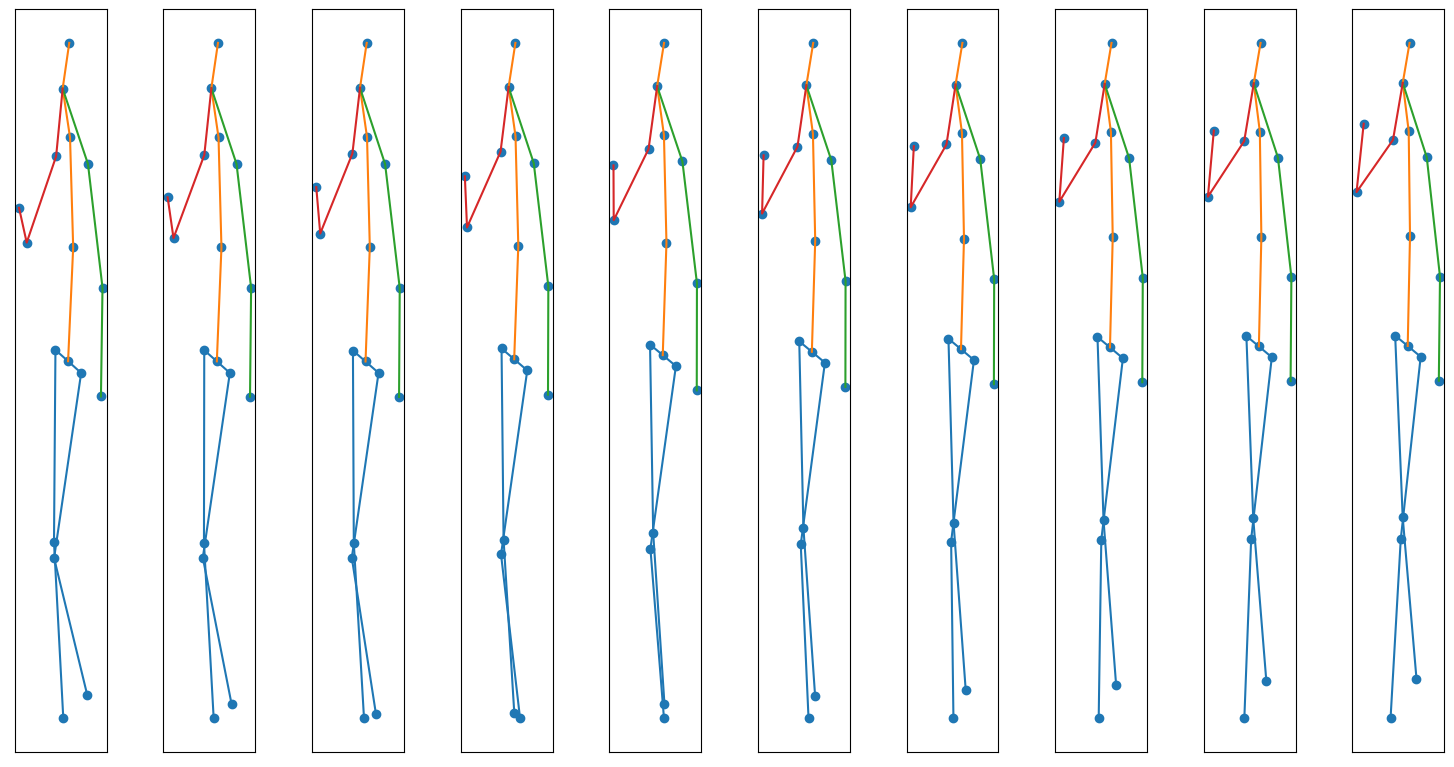

In [115]:
visualize_frames(sampled_dataY_short_term[50000])

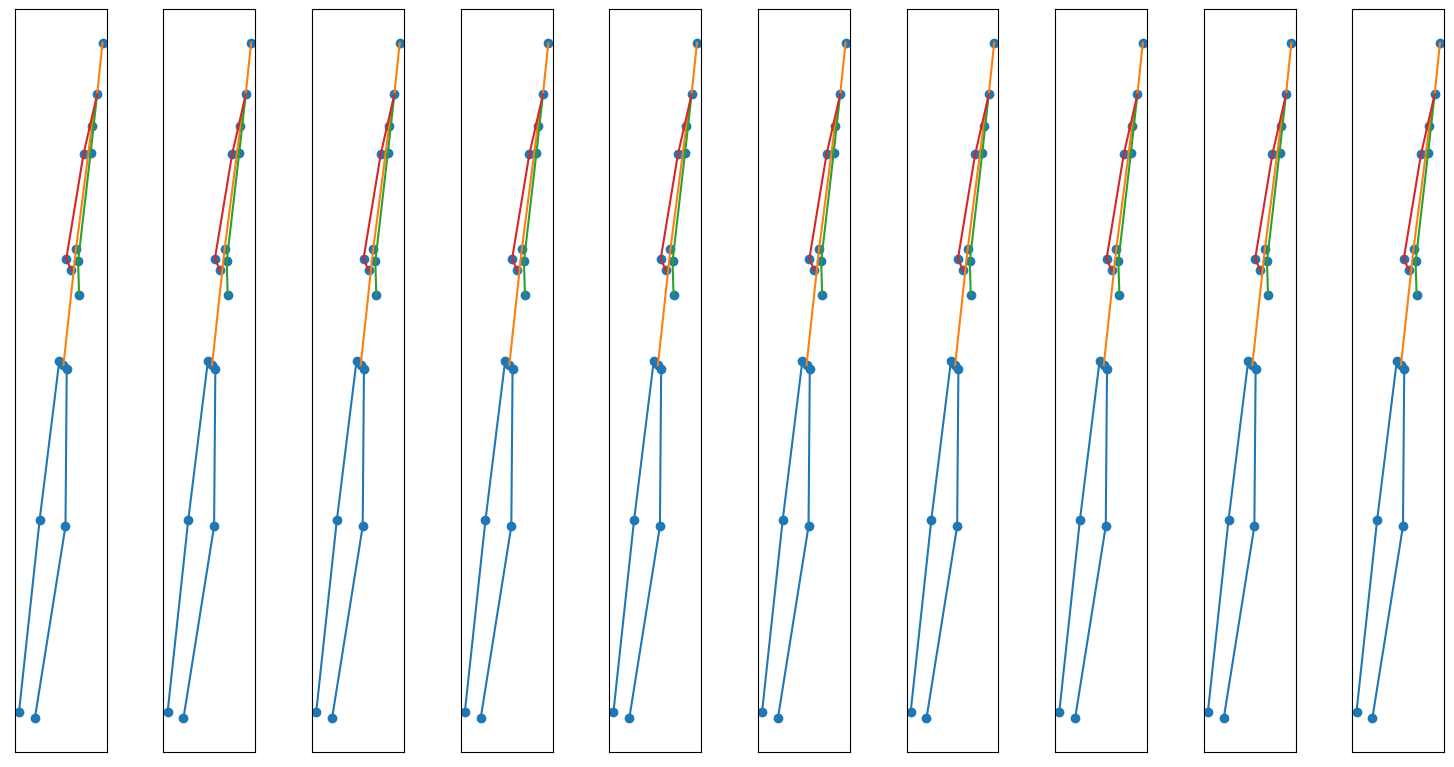

In [114]:
visualize_frames(predictions_simple_RNN6[5000])

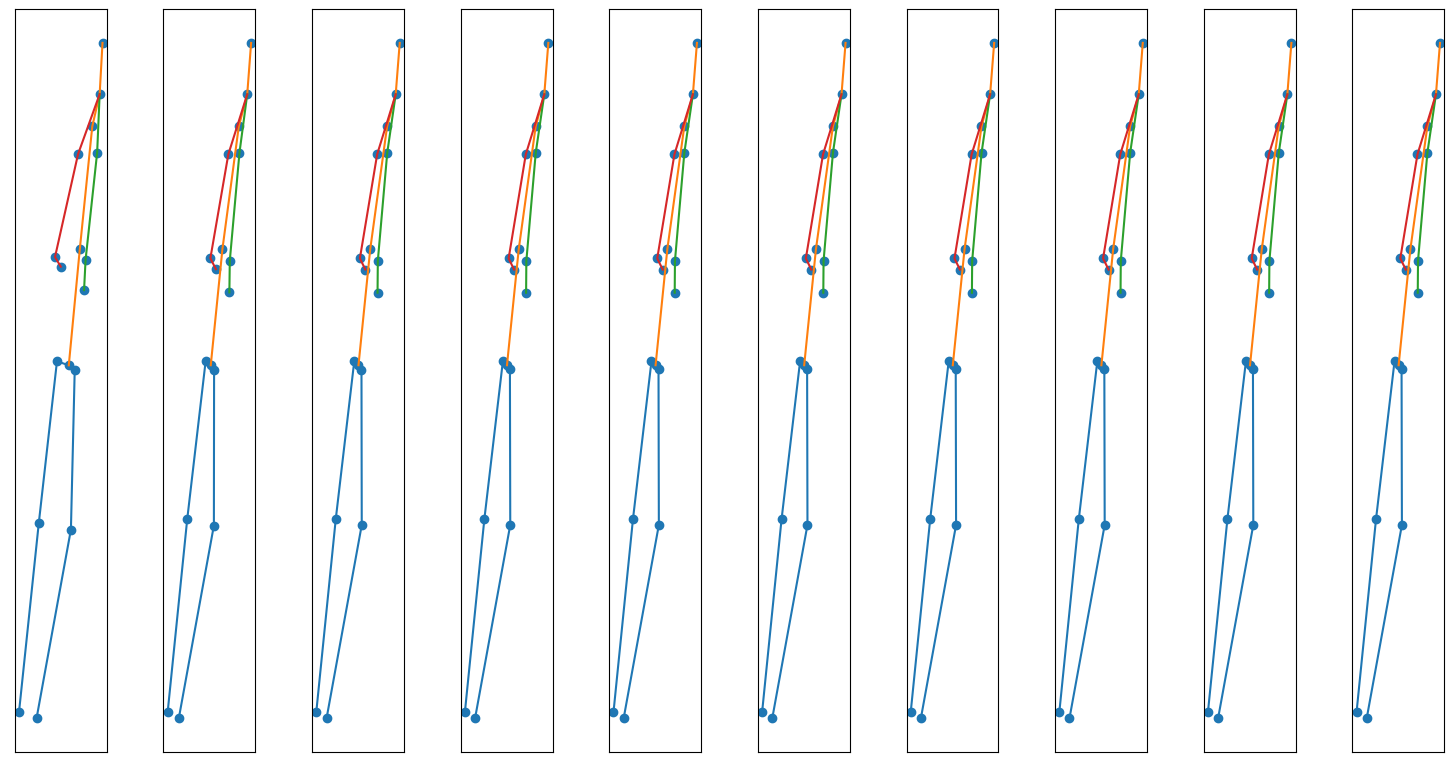

In [105]:
visualize_frames(predictions_simple_RNN5[0])

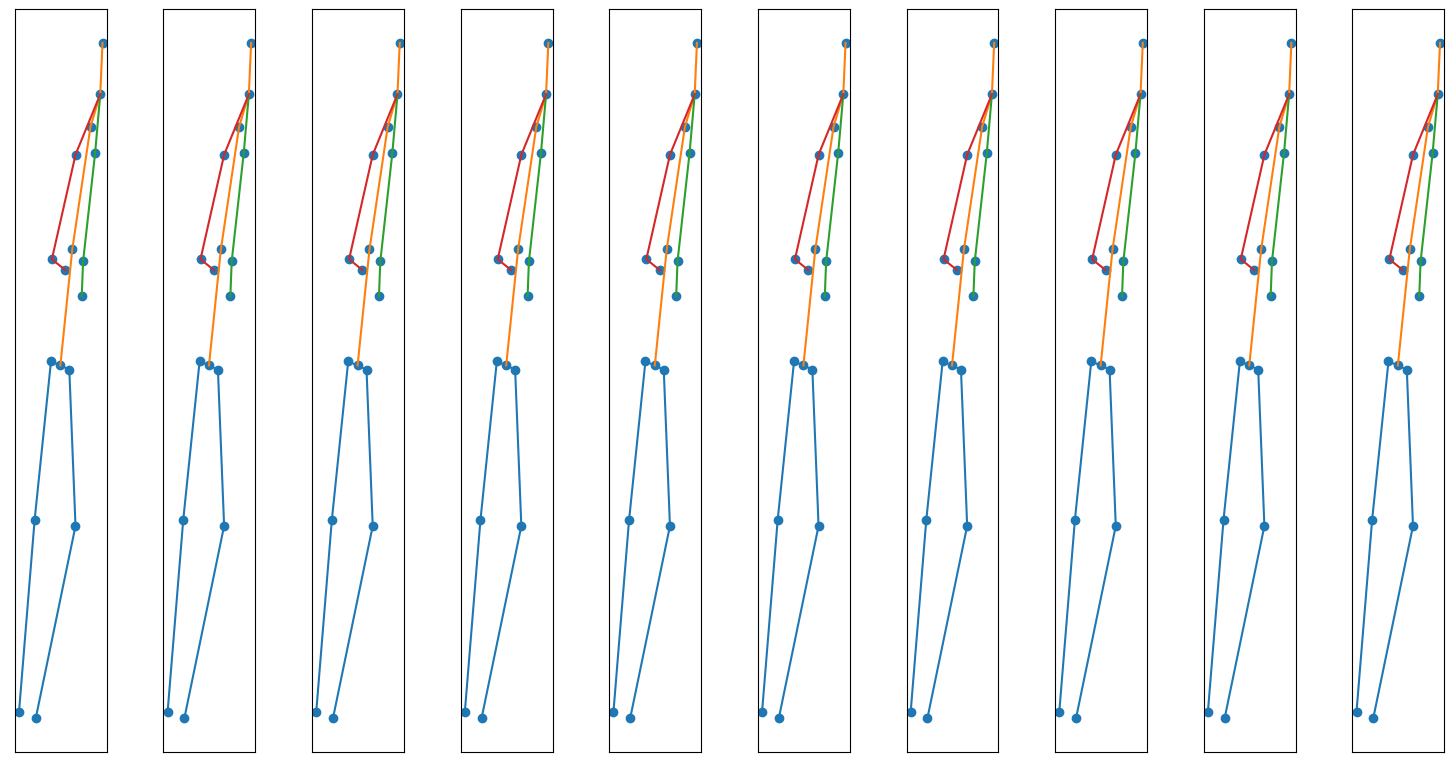

In [108]:
visualize_frames(predictions_simple_RNN4[50000])

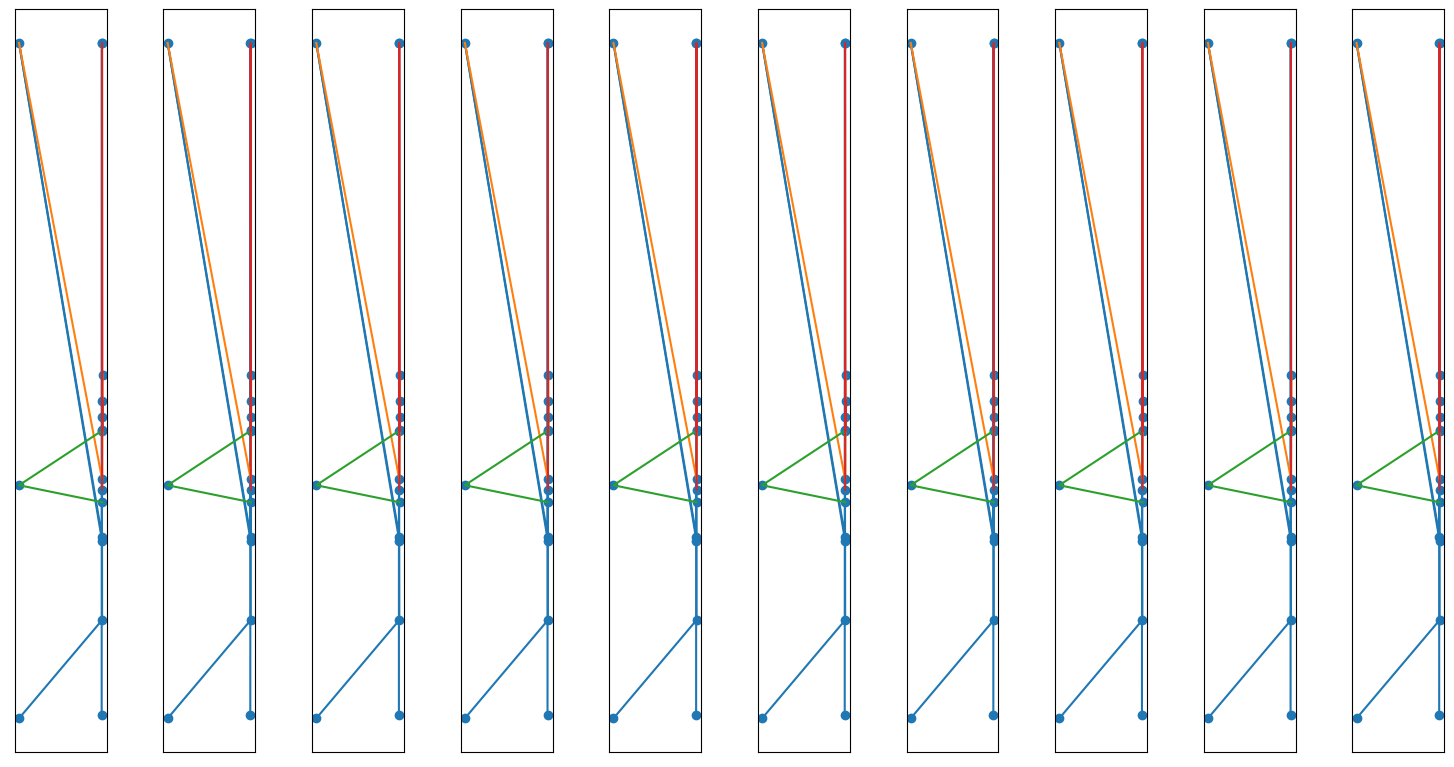

In [82]:
visualize_frames(predictions_simple_RNN2[1000])

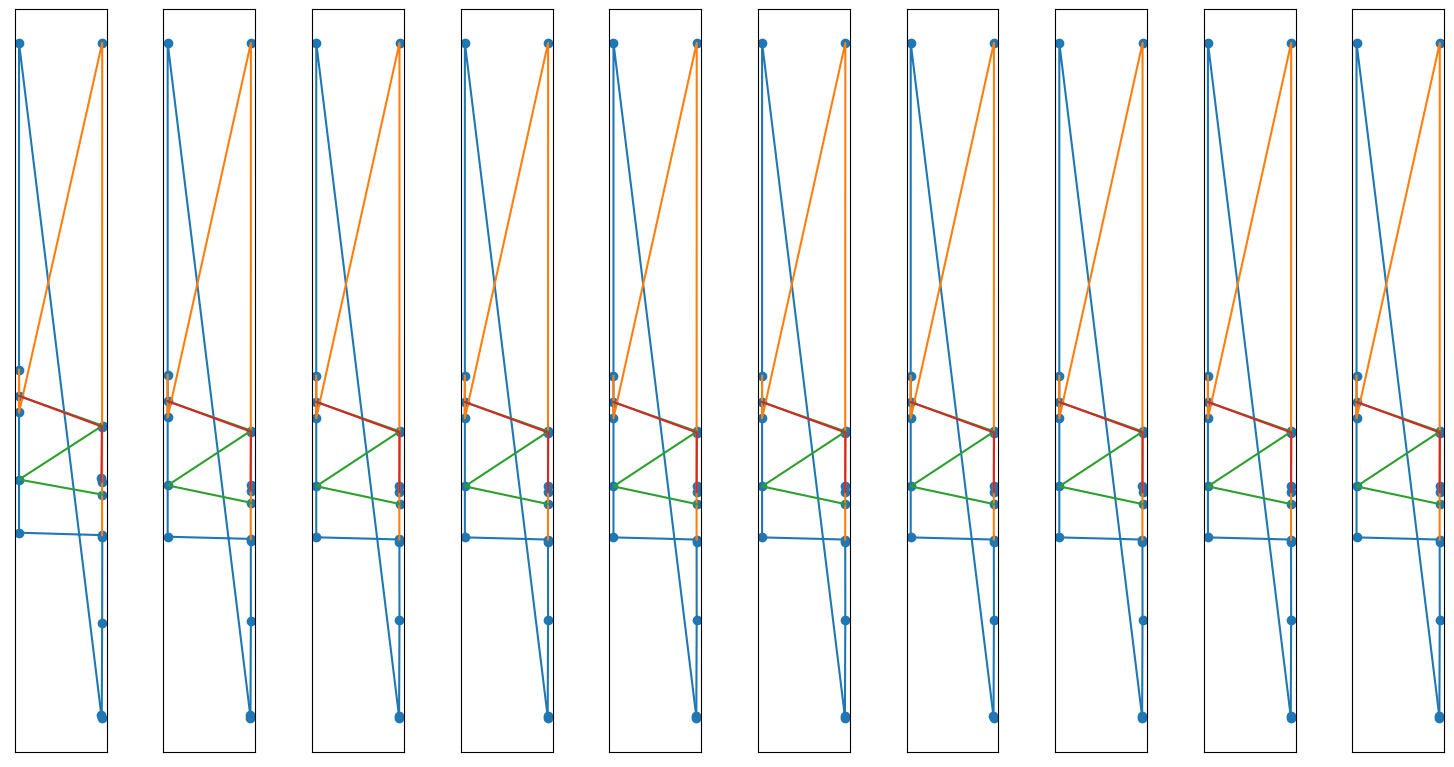

In [77]:
visualize_frames(predictions_simple_RNN1[1000])

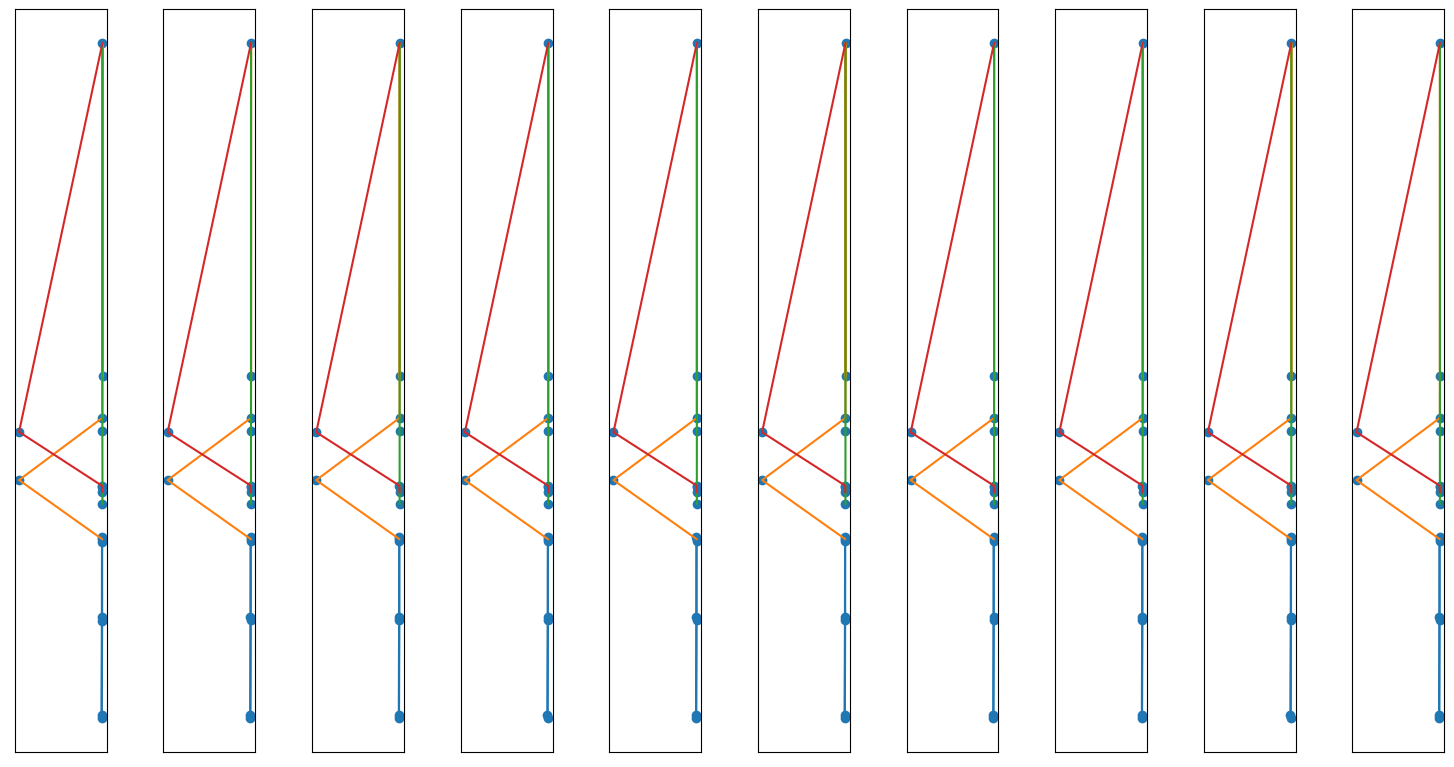

In [59]:
visualize_frames(predictions[1300, 0:20:2], num_frames_to_visualize=10)

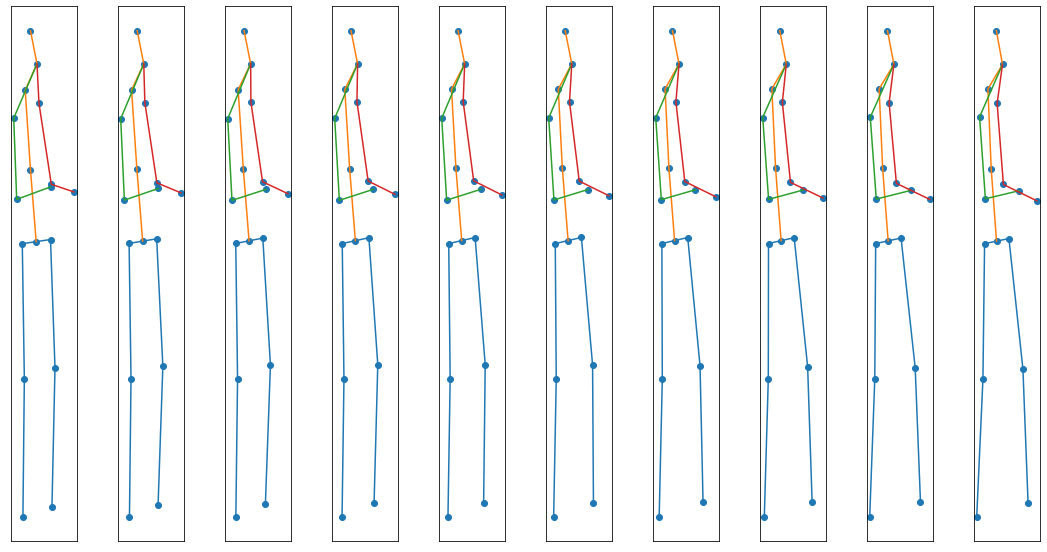

In [ ]:
visualize_frames(preprocessed_downsampled_dataX[1300], num_frames_to_visualize=10)

In [26]:
print(len(tf.config.list_physical_devices('GPU')))

1


## Saving models

In [ ]:
glocal_interpolation_only.save('minterpolation_only_downsampled20',save_format='tf')

# References

[1] https://github.com/una-dinosauria/3d-pose-baseline/blob/master/src/data_utils.py

[2] Gopalakrishnan, Anand, et al. "A neural temporal model for human motion prediction." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2019

[3] https://github.com/cr7anand/neural_temporal_models